# semantics-pathtools demo notebook

In this notebook, we show how to use the semantic relatedness extraction tools for human navigational paths provided in this repository. We demonstrate the functionality with the WikiSpeedia navigation data obtainable from https://snap.stanford.edu/data/wikispeedia.html.

First off, we prepare a PySpark context where our code runs on. We preprocess human navigational paths collected in the online game WikiSpeedia (http://www.wikispeedia.net) by West et al. and give a quick characterization of these paths.

After this, we show how to apply our model on these paths in order to construct co-occurrence based vectors for each page in the paths, which can be used to calculate the semantic relatedness between the two represented concepts.

Finally, we evaluate the constructed vector models on human intuition of semantic relatedness, concretely by comparing the semantic relatedness scores produced by our model to those collected from human judgment. At the end, we show that our results are statistically signficant.

The methods implemented are described in the following papers:
* Singer, Philipp, Niebler, Thomas, Strohmaier, Markus and Hotho, Andreas. "Computing Semantic Relatedness from Human Navigational Paths: A Case Study on Wikipedia." IJSWIS 9 , no. 4 (2013): 41--70.
* Niebler, Thomas, Schlör, Daniel, Becker, Martin and Hotho, Andreas. "Extracting Semantics from Unconstrained Navigation on Wikipedia." KI -- Künstliche Intelligenz 30 , no. 2 (2016): 163--168.
* Dallmann, Alexander, Niebler, Thomas, Lemmerich, Florian and Hotho, Andreas. "Extracting Semantics from Random Walks on Wikipedia: Comparing Learning and Counting Methods." Paper presented at the WikiWorkshop at the 10th International Conference on Web and Social Media, 2016.

All of these papers can be found in my BibSonomy account at https://www.bibsonomy.org/user/thoni/myown%20wikipedia.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

## 0. preparations

Load a PySpark Context

In [2]:
import pyspark
sc = pyspark.SparkContext()

Load the WikiSpeedia paths and prepare them, e.g. remove backclicks altogether.

In [3]:
from utils.wikispeedia import remove_backclicks

paths = sc.textFile("../data/wikispeedia/paths_finished.tsv")\
        .union(sc.textFile("../data/wikispeedia/paths_unfinished.tsv"))\
        .filter(lambda line: not line.startswith("#") and len(line) > 0)\
        .map(lambda line: line.split("\t")[3].split(";"))\
        .map(remove_backclicks)

The dataset should contain 24,875 unfinished and 51,318 finished paths over 4,604 articles:

In [4]:
paths.count()

76193

In [5]:
paths.flatMap(lambda x: x).distinct().count()

4182

We can see that not every page in the WikiSpeedia dataset has been visited. In fact, 522 pages have never been visited at all.

The average path length amounts to:

In [6]:
round(paths.map(len).sum() / paths.count(), 3)

5.37

The logarithmic path length distribution is as follows:

In [7]:
path_lengths = pd.DataFrame(sorted(paths.map(len).countByValue().items()),
                            columns=["length", "count"])\
                    .set_index("length")
path_lengths["count"] = path_lengths["count"].apply(np.log)

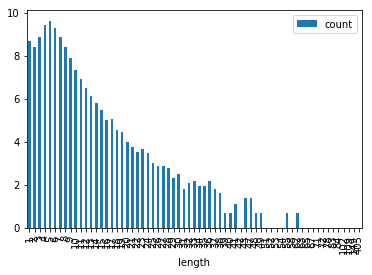

In [8]:
path_lengths.plot(kind="bar")

## 1. construct co-occurrence based vectors

In [9]:
from sempaths.pagesim import PageSim

In [10]:
sps = PageSim(sc)

Construct the vocabulary map by fitting the model to the path set

In [11]:
sps.fit(paths)

Construct the vectors with a page co-occurrence window of size 3, in the basic counting format by Singer et al., the binarized variant by Niebler et al. and a tfidf variant.

In [12]:
vectors = dict([(entry[0].lower(), entry[1]) for entry in sps.transform(paths)])
vectors_bin = dict([(entry[0].lower(), entry[1]) for entry in sps.transform(paths, binary=True)])
vectors_tfidf = dict([(entry[0].lower(), entry[1]) for entry in sps.transform(paths, tfidf=True)])

Ensure that we have a vector for all 4182 pages.

In [13]:
len(vectors)

4179

We can see that we do not have any vectors for 3 pages. This is due to those pages having no context except themselves inside a window size of 3, because the visiting user only visited the page itself. This is also in line with the fact that there are many "paths" with only a path length of 1.

## 2. semantic evaluation

In [14]:
from utils.evaluation import prepare_dataset, load_eval_df, semeval

Load the WS353 dataset and prepare it accordingly. In this scenario, we use the matched Wikipedia pages for each word instead of the actual words themselves. The matching was done by http://www.nzdl.org/wikipediaSimilarity/ and http://www.philippsinger.info/wikisempaths.html.

In [15]:
ws353 = load_eval_df("ws353")
ws353["termA"] = ws353["matchA"]
ws353["termB"] = ws353["matchB"]

Find all matchable pairs in WS353:

In [16]:
ws353p = prepare_dataset(ws353, vectors)
ws353p_bin = prepare_dataset(ws353, vectors_bin)
ws353p_tfidf = prepare_dataset(ws353, vectors_tfidf)

In [17]:
len(ws353p)

48

Finally, evaluate the semantic quality of the produced vectors by calculating the Spearman correlation of human relatedness scores and our model's relatedness scores.

In [18]:
(semeval(ws353p), semeval(ws353p_bin), semeval(ws353p_tfidf))

(0.71820205200586296, 0.67324502269956665, 0.66733631029686979)

We also test those scores for statistical significance using Fisher's z-score transformation. More precisely, we test the hypothesis that our score is significantly different from a correlation score 0 at a level of $p < 0.05$. See https://www.bibsonomy.org/bibtex/17d9e6935241d13274e2914b6f920c7e/thoni for further information.

In [19]:
from utils.evaluation import p

In [20]:
(p(semeval(ws353p), 0, 48) < 0.05, p(semeval(ws353p_bin), 0, 48) < 0.05, p(semeval(ws353p_tfidf), 0, 48) < 0.05)

(True, True, True)

Finally, we have to bear in mind that the evaluation was performed only on a small subset of the actual WordSimilarity-353 dataset, so there might be some issues with the comparability of the evaluation scores with other scores, e.g. from Word2Vec.